In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

train_dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

print(f"Nombre d'images dans l'ensemble d'entraînement : {len(train_dataset)}")
print(f"Nombre d'images dans l'ensemble de test : {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Nombre d'images dans l'ensemble d'entraînement : 50000
Nombre d'images dans l'ensemble de test : 10000


In [4]:
import torch
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Pas de GPU")


GPU disponible : True
Nom du GPU : NVIDIA GeForce RTX 3070 Laptop GPU


Files already downloaded and verified
Files already downloaded and verified


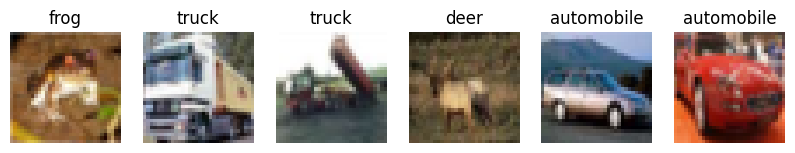

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def visualize_images(dataset, n_images=6):
    """Function to visualize sample images from the dataset."""
    classes = dataset.classes
    data_iter = iter(DataLoader(dataset, batch_size=n_images))
    images, labels = next(data_iter)
    
    images = images / 2 + 0.5  
    
    plt.figure(figsize=(10, 5))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

visualize_images(train_dataset)


In [6]:
from torch.utils.data import random_split

simclr_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), 
    transforms.GaussianBlur(kernel_size=3), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset  
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  
        if isinstance(image, torch.Tensor):
            raise TypeError("Dataset provided tensors, but PIL images are expected.")
        image1 = self.transform(image) 
        image2 = self.transform(image)  
        return image1, image2

raw_train_dataset = CIFAR10(root="./data", train=True, download=False)

train_size = int(0.8 * len(raw_train_dataset))
val_size = int(0.1 * len(raw_train_dataset))
test_size = len(raw_train_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(raw_train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(SimCLRDataset(train_subset, simclr_transforms), batch_size=64, shuffle=True)
val_loader = DataLoader(SimCLRDataset(val_subset, simclr_transforms), batch_size=64, shuffle=False)
test_loader = DataLoader(SimCLRDataset(test_subset, simclr_transforms), batch_size=64, shuffle=False)


In [ ]:
import torch.nn as nn
import torchvision.models as models

class SimCLR(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = models.NT-Xent Loss : 0.5.(pretrained=False, num_classes=out_dim)
        num_features = self.encoder.fc.in_features
        
        self.encoder.fc = nn.Identity()
        
        self.projection_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

simclr_model = SimCLR(base_model='resnet18', out_dim=128)
print(simclr_model)


SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

c:\Users\PC-14\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC-14\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
import torch
import torch.nn.functional as F

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]

        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        z = torch.cat([z_i, z_j], dim=0)

        similarity_matrix = torch.matmul(z, z.T) 

        mask = torch.eye(2 * batch_size, device=z.device).bool()
        similarity_matrix.masked_fill_(mask, float('-inf'))

        positive_sim = torch.cat(
            [torch.diagonal(similarity_matrix, batch_size), torch.diagonal(similarity_matrix, -batch_size)]
        )

        numerator = torch.exp(positive_sim / self.temperature)
        denominator = torch.sum(torch.exp(similarity_matrix / self.temperature), dim=1)

        loss = -torch.log(numerator / denominator[:batch_size].repeat(2))

        return loss.mean()

nt_xent_loss = NTXentLoss(temperature=0.5)
print(nt_xent_loss)


NTXentLoss()


In [46]:
import torch.optim as optim
from tqdm import tqdm



num_epochs = 20  
learning_rate = 0.001


def train_with_validation(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=30):
    model.train()
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images1, images2 in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]"):
            images1, images2 = images1.to(device), images2.to(device)
            z_i = model(images1)
            z_j = model(images2)

            loss = loss_fn(z_i, z_j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images1, images2 in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]"):
                images1, images2 = images1.to(device), images2.to(device)
                z_i = model(images1)
                z_j = model(images2)

                loss = loss_fn(z_i, z_j)
                running_val_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        val_loss = running_val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}] -> Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses


optimizer = optim.Adam(simclr_model.parameters(), lr=0.001)

train_losses, val_losses = train_with_validation(simclr_model, train_loader, val_loader, nt_xent_loss, optimizer, device, num_epochs=30)

Epoch 1/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.70it/s]


Epoch [1/30] -> Training Loss: 3.3247, Validation Loss: 3.2468


Epoch 2/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.82it/s]


Epoch [2/30] -> Training Loss: 3.2066, Validation Loss: 3.1895


Epoch 3/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.49it/s]


Epoch [3/30] -> Training Loss: 3.1691, Validation Loss: 3.1681


Epoch 4/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.56it/s]


Epoch [4/30] -> Training Loss: 3.1417, Validation Loss: 3.1529


Epoch 5/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.68it/s]


Epoch [5/30] -> Training Loss: 3.1226, Validation Loss: 3.1297


Epoch 6/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.59it/s]


Epoch [6/30] -> Training Loss: 3.1090, Validation Loss: 3.1326


Epoch 7/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.63it/s]


Epoch [7/30] -> Training Loss: 3.0981, Validation Loss: 3.1055


Epoch 8/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.54it/s]


Epoch [8/30] -> Training Loss: 3.0869, Validation Loss: 3.1022


Epoch 9/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.54it/s]


Epoch [9/30] -> Training Loss: 3.0771, Validation Loss: 3.0864


Epoch 10/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.58it/s]


Epoch [10/30] -> Training Loss: 3.0682, Validation Loss: 3.0803


Epoch 11/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.63it/s]


Epoch [11/30] -> Training Loss: 3.0625, Validation Loss: 3.0764


Epoch 12/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.63it/s]


Epoch [12/30] -> Training Loss: 3.0569, Validation Loss: 3.0755


Epoch 13/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.57it/s]


Epoch [13/30] -> Training Loss: 3.0525, Validation Loss: 3.0679


Epoch 14/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.60it/s]


Epoch [14/30] -> Training Loss: 3.0463, Validation Loss: 3.0636


Epoch 15/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.58it/s]


Epoch [15/30] -> Training Loss: 3.0431, Validation Loss: 3.0686


Epoch 16/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.72it/s]


Epoch [16/30] -> Training Loss: 3.0377, Validation Loss: 3.0536


Epoch 17/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.48it/s]


Epoch [17/30] -> Training Loss: 3.0351, Validation Loss: 3.0548


Epoch 18/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch [18/30] -> Training Loss: 3.0321, Validation Loss: 3.0509


Epoch 19/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.55it/s]


Epoch [19/30] -> Training Loss: 3.0283, Validation Loss: 3.0442


Epoch 20/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.73it/s]


Epoch [20/30] -> Training Loss: 3.0267, Validation Loss: 3.0457


Epoch 21/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Epoch [21/30] -> Training Loss: 3.0233, Validation Loss: 3.0430


Epoch 22/30 [Validation]: 100%|██████████| 79/79 [00:15<00:00,  5.17it/s]


Epoch [22/30] -> Training Loss: 3.0208, Validation Loss: 3.0433


Epoch 23/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.62it/s]


Epoch [23/30] -> Training Loss: 3.0190, Validation Loss: 3.0372


Epoch 24/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.69it/s]


Epoch [24/30] -> Training Loss: 3.0171, Validation Loss: 3.0372


Epoch 25/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.52it/s]


Epoch [25/30] -> Training Loss: 3.0157, Validation Loss: 3.0399


Epoch 26/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Epoch [26/30] -> Training Loss: 3.0133, Validation Loss: 3.0325


Epoch 27/30 [Validation]: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


Epoch [27/30] -> Training Loss: 3.0112, Validation Loss: 3.0304


Epoch 28/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Epoch [28/30] -> Training Loss: 3.0090, Validation Loss: 3.0351


Epoch 29/30 [Validation]: 100%|██████████| 79/79 [00:13<00:00,  5.66it/s]


Epoch [29/30] -> Training Loss: 3.0085, Validation Loss: 3.0280


Epoch 30/30 [Validation]: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]

Epoch [30/30] -> Training Loss: 3.0058, Validation Loss: 3.0314


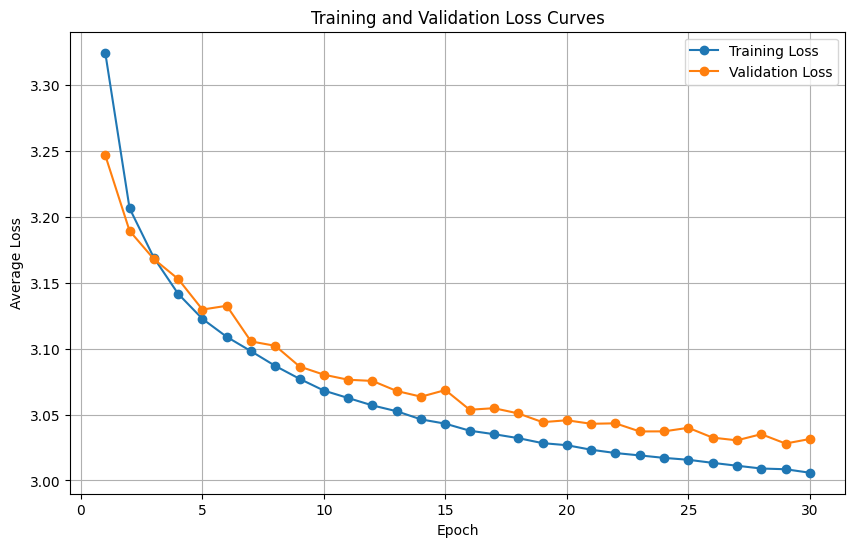

In [47]:
def plot_training_validation_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
    plt.title("Training and Validation Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_validation_curves(train_losses, val_losses)


In [48]:
def evaluate_on_test(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images1, images2 in tqdm(test_loader, desc="Evaluating on Test Set"):
            images1, images2 = images1.to(device), images2.to(device)
            z_i = model(images1)
            z_j = model(images2)

            loss = loss_fn(z_i, z_j)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss

test_loss = evaluate_on_test(simclr_model, test_loader, nt_xent_loss, device)


Evaluating on Test Set: 100%|██████████| 79/79 [00:15<00:00,  4.94it/s]

Test Loss: 3.0307


Files already downloaded and verified
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
Embeddings shape: (10000, 512)
Labels shape: (10000,)


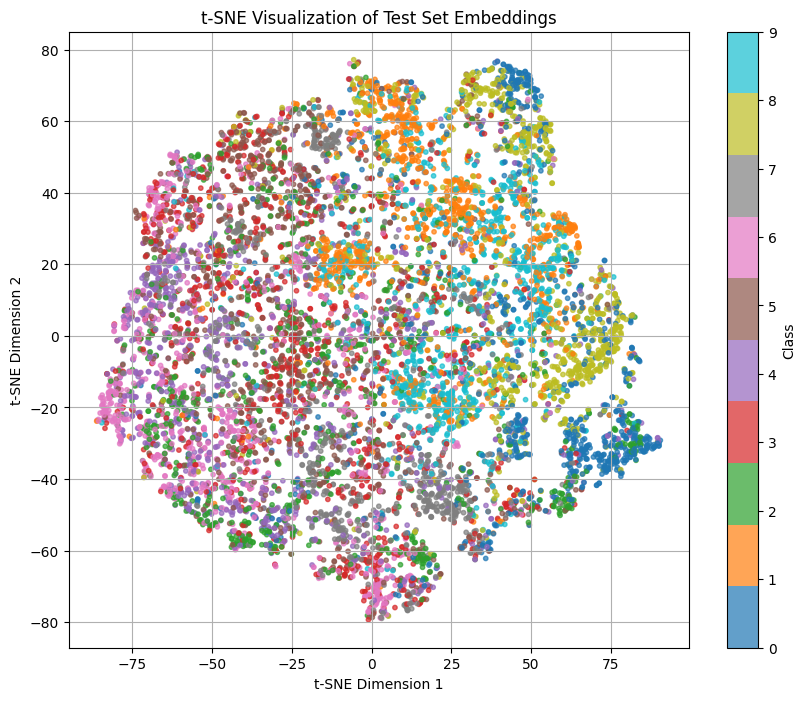

In [50]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
raw_test_dataset = CIFAR10(root="./data", train=False, download=True, transform=test_transform)

test_loader = DataLoader(raw_test_dataset, batch_size=64, shuffle=False)

for images, labels in test_loader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

def extract_embeddings(model, dataloader, device):
    model.eval()
    model.to(device)
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            z = model.encoder(images) 
            embeddings.append(z.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_embeddings, test_labels = extract_embeddings(simclr_model, test_loader, device)

print(f"Embeddings shape: {test_embeddings.shape}")
print(f"Labels shape: {test_labels.shape}")

tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(test_embeddings)

def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.colorbar(scatter, label='Class')
    plt.title("t-SNE Visualization of Test Set Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

plot_embeddings(reduced_embeddings, test_labels)

In [9]:
import os
import pandas as pd
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision.transforms import Grayscale

dataset_path = "covid-chestxray-dataset" 
metadata_path = os.path.join(dataset_path, "metadata.csv")
image_path = os.path.join(dataset_path, "images")

metadata = pd.read_csv(metadata_path)
print(f"Metadata loaded: {metadata.shape[0]} entries")

filtered_metadata = metadata[metadata["view"] == "PA"]
print(f"Filtered metadata: {filtered_metadata.shape[0]} PA view images")


class COVIDXrayDataset(Dataset):
    def __init__(self, metadata, image_dir, transform=None):
        self.metadata = metadata
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.metadata.iloc[idx]["filename"])
        label = self.metadata.iloc[idx]["finding"] 
        
        image = Image.open(img_name).convert("L")  
        if self.transform:
            image = self.transform(image)
        
        return image, label

covid_transforms = Compose([
    Grayscale(num_output_channels=3),  
    Resize((224, 224)),  
    RandomHorizontalFlip(p=0.5), 
    RandomRotation(10),  
    ToTensor(),  
    Normalize(mean=[0.5], std=[0.5]) 
])


covid_dataset = COVIDXrayDataset(filtered_metadata, image_path, transform=covid_transforms)

train_size = int(0.8 * len(covid_dataset))
val_size = int(0.1 * len(covid_dataset))
test_size = len(covid_dataset) - train_size - val_size
train_subset, val_subset, test_subset = random_split(covid_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_subset)}")


Metadata loaded: 950 entries
Filtered metadata: 344 PA view images
Training set size: 275
Validation set size: 34
Test set size: 35


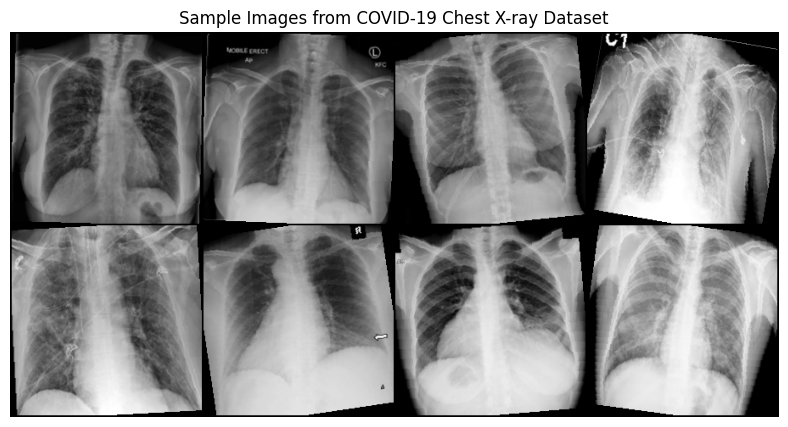

In [10]:
import matplotlib.pyplot as plt
import torchvision

def show_batch(loader):
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images[:8], nrow=4, normalize=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0), cmap="gray")
    plt.title("Sample Images from COVID-19 Chest X-ray Dataset")
    plt.axis("off")
    plt.show()

show_batch(train_loader)


Epoch 1/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch [1/50], Train Loss: 2.2982, Validation Loss: 3.6956


Epoch 2/50 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch [2/50], Train Loss: 0.9553, Validation Loss: 2.8660


Epoch 3/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch [3/50], Train Loss: 0.6076, Validation Loss: 2.5744


Epoch 4/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch [4/50], Train Loss: 0.4238, Validation Loss: 1.3698


Epoch 5/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch [5/50], Train Loss: 0.2849, Validation Loss: 0.5877


Epoch 6/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch [6/50], Train Loss: 0.2181, Validation Loss: 0.3718


Epoch 7/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch [7/50], Train Loss: 0.1757, Validation Loss: 0.2405


Epoch 8/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch [8/50], Train Loss: 0.1790, Validation Loss: 0.2350


Epoch 9/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [9/50], Train Loss: 0.1301, Validation Loss: 0.1525


Epoch 10/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [10/50], Train Loss: 0.1363, Validation Loss: 0.1757


Epoch 11/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [11/50], Train Loss: 0.1312, Validation Loss: 0.2163


Epoch 12/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch [12/50], Train Loss: 0.1171, Validation Loss: 0.1089


Epoch 13/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch [13/50], Train Loss: 0.0917, Validation Loss: 0.0645


Epoch 14/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch [14/50], Train Loss: 0.1127, Validation Loss: 0.1373


Epoch 15/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [15/50], Train Loss: 0.0909, Validation Loss: 0.1149


Epoch 16/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch [16/50], Train Loss: 0.1048, Validation Loss: 0.0503


Epoch 17/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [17/50], Train Loss: 0.0867, Validation Loss: 0.1182


Epoch 18/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [18/50], Train Loss: 0.1041, Validation Loss: 0.1113


Epoch 19/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [19/50], Train Loss: 0.1051, Validation Loss: 0.1344


Epoch 20/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch [20/50], Train Loss: 0.0966, Validation Loss: 0.1183


Epoch 21/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch [21/50], Train Loss: 0.0870, Validation Loss: 0.2925


Epoch 22/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [22/50], Train Loss: 0.1007, Validation Loss: 0.0908


Epoch 23/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [23/50], Train Loss: 0.0782, Validation Loss: 0.1212


Epoch 24/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch [24/50], Train Loss: 0.0747, Validation Loss: 0.0948


Epoch 25/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [25/50], Train Loss: 0.0820, Validation Loss: 0.0465


Epoch 26/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch [26/50], Train Loss: 0.0809, Validation Loss: 0.0694


Epoch 27/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [27/50], Train Loss: 0.0919, Validation Loss: 0.0617


Epoch 28/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch [28/50], Train Loss: 0.0833, Validation Loss: 0.0372


Epoch 29/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [29/50], Train Loss: 0.0617, Validation Loss: 0.0461


Epoch 30/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [30/50], Train Loss: 0.0659, Validation Loss: 0.0399


Epoch 31/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch [31/50], Train Loss: 0.0517, Validation Loss: 0.0631


Epoch 32/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch [32/50], Train Loss: 0.0541, Validation Loss: 0.0494


Epoch 33/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch [33/50], Train Loss: 0.0508, Validation Loss: 0.0553


Epoch 34/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch [34/50], Train Loss: 0.0491, Validation Loss: 0.0510


Epoch 35/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch [35/50], Train Loss: 0.0529, Validation Loss: 0.0495


Epoch 36/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [36/50], Train Loss: 0.0430, Validation Loss: 0.0351


Epoch 37/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [37/50], Train Loss: 0.0603, Validation Loss: 0.0273


Epoch 38/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch [38/50], Train Loss: 0.0638, Validation Loss: 0.0841


Epoch 39/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [39/50], Train Loss: 0.0519, Validation Loss: 0.0835


Epoch 40/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch [40/50], Train Loss: 0.0632, Validation Loss: 0.0664


Epoch 41/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [41/50], Train Loss: 0.0521, Validation Loss: 0.0501


Epoch 42/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch [42/50], Train Loss: 0.0599, Validation Loss: 0.0264


Epoch 43/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch [43/50], Train Loss: 0.0566, Validation Loss: 0.0919


Epoch 44/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch [44/50], Train Loss: 0.0471, Validation Loss: 0.0706


Epoch 45/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch [45/50], Train Loss: 0.0491, Validation Loss: 0.0522


Epoch 46/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch [46/50], Train Loss: 0.0442, Validation Loss: 0.0195


Epoch 47/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch [47/50], Train Loss: 0.0516, Validation Loss: 0.0307


Epoch 48/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch [48/50], Train Loss: 0.0557, Validation Loss: 0.0652


Epoch 49/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch [49/50], Train Loss: 0.0468, Validation Loss: 0.0489


Epoch 50/50 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Epoch [50/50], Train Loss: 0.0416, Validation Loss: 0.0651


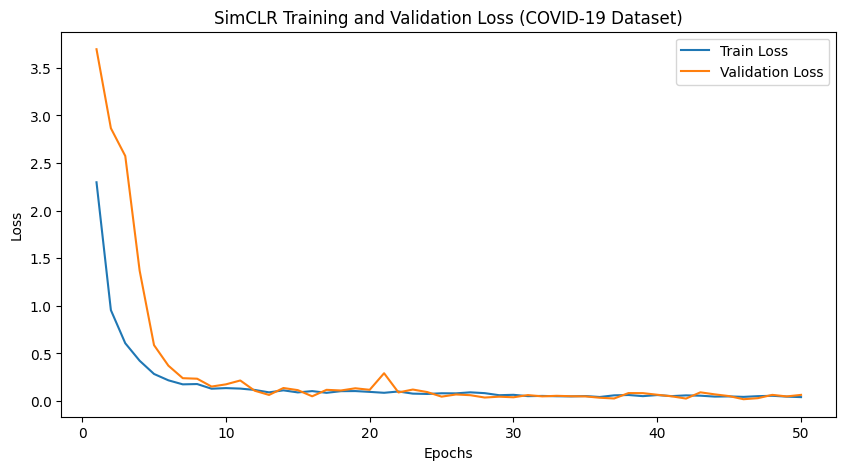

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


simclr_model = SimCLR()
simclr_model.to(device)

temperature = 0.1
nt_xent_loss = NTXentLoss(temperature)

optimizer = optim.Adam(simclr_model.parameters(), lr=0.0005)

def train_simclr(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, save_path="simclr_covid_model.pth"):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]"):

            images1, images2 = images, images.clone()
            images1, images2 = images1.to(device), images2.to(device)

            z_i = model(images1)
            z_j = model(images2)

            loss = loss_fn(z_i, z_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]"):
                images1, images2 = images, images.clone()
                images1, images2 = images1.to(device), images2.to(device)

                z_i = model(images1)
                z_j = model(images2)

                loss = loss_fn(z_i, z_j)
                running_val_loss += loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

        torch.save(model.state_dict(), f"{save_path}_epoch{epoch + 1}.pth")

    return train_losses, val_losses

num_epochs = 50
train_losses, val_losses = train_simclr(simclr_model, train_loader, val_loader, nt_xent_loss, optimizer, device, num_epochs=num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SimCLR Training and Validation Loss (COVID-19 Dataset)")
plt.legend()
plt.show()


In [14]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

simclr_model = SimCLR()
simclr_model.to(device)

checkpoint_path = "simclr_covid_model.pth_epoch50.pth"  
simclr_model.load_state_dict(torch.load(checkpoint_path, map_location=device))


simclr_model.eval()

print("Model loaded successfully!")


def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            images, targets = batch 
            images = images.to(device)
            z = model.encoder(images)  
            embeddings.append(z.cpu().numpy())
            

            if isinstance(targets, (list, tuple)):
                targets = [int(t) if isinstance(t, str) and t.isdigit() else t for t in targets]
            elif isinstance(targets, str) and targets.isdigit():
                targets = int(targets)

            labels.extend(np.array(targets))

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    return embeddings, labels


test_embeddings, test_labels = extract_embeddings(simclr_model, test_loader, device)

np.save("test_embeddings.npy", test_embeddings)
np.save("test_labels.npy", test_labels)

print(f"Extracted embeddings shape: {test_embeddings.shape}")
print(f"Extracted labels shape: {test_labels.shape}")


c:\Users\PC-14\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC-14\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\PC-14\AppData\Local\Temp\ipykernel_5128\3133768808.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

Model loaded successfully!


Extracting embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Extracted embeddings shape: (35, 512)
Extracted labels shape: (35,)


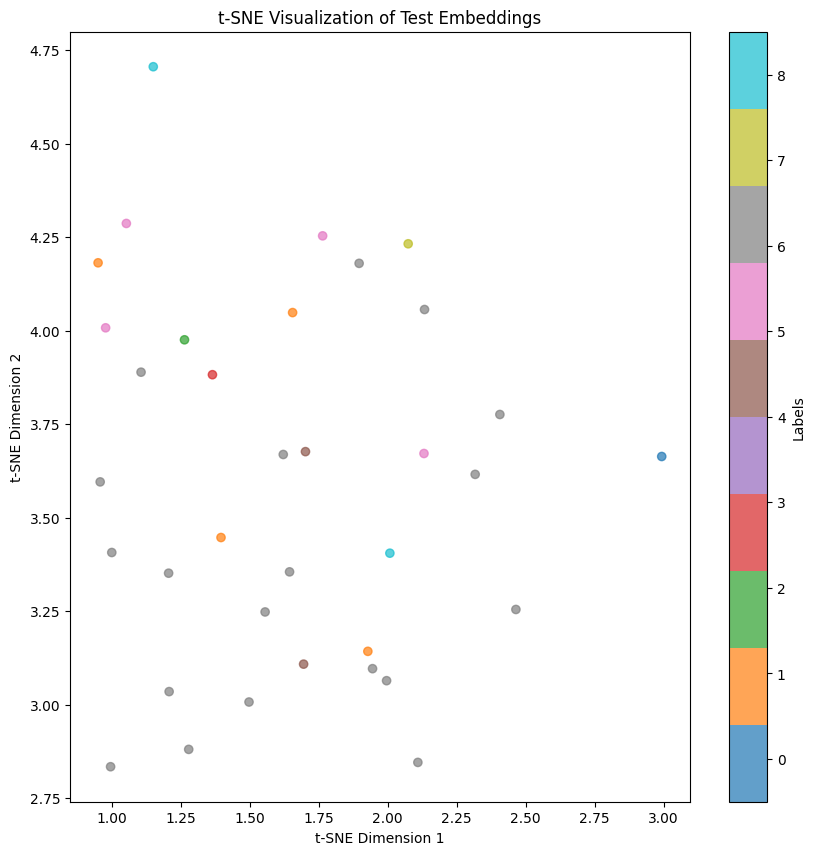

Label Mapping:
No Finding: 0
Pneumonia: 1
Pneumonia/Bacterial: 2
Pneumonia/Bacterial/Chlamydophila: 3
Pneumonia/Bacterial/Streptococcus: 4
Pneumonia/Fungal/Pneumocystis: 5
Pneumonia/Viral/COVID-19: 6
Pneumonia/Viral/SARS: 7
Tuberculosis: 8


In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


test_embeddings = np.load("test_embeddings.npy")
test_labels = np.load("test_labels.npy")


unique_labels = np.unique(test_labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_labels = np.array([label_to_int[label] for label in test_labels])


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(test_embeddings)


plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=int_labels,
    cmap='tab10',
    alpha=0.7
)
plt.colorbar(scatter, ticks=range(len(unique_labels)), label="Labels")
plt.clim(-0.5, len(unique_labels) - 0.5)
plt.title("t-SNE Visualization of Test Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

print("Label Mapping:")
for label, idx in label_to_int.items():
    print(f"{label}: {idx}")


In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def retrieve_similar_images(query_embedding, dataset_embeddings, dataset_images, top_k=5):
    
    similarities = cosine_similarity(query_embedding.reshape(1, -1), dataset_embeddings).flatten()
    
    top_k_indices = similarities.argsort()[::-1][:top_k]
    return top_k_indices, similarities[top_k_indices]


In [22]:
import matplotlib.pyplot as plt


def visualize_retrieval(query_image, retrieved_images, similarities):

    if isinstance(query_image, torch.Tensor):
        query_image = query_image.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.imshow(query_image, cmap="gray" if query_image.shape[-1] == 1 else None)
    plt.title("Query Image")
    plt.axis("off")
    
    for i, (retrieved_image, similarity) in enumerate(zip(retrieved_images, similarities), start=2):
        if isinstance(retrieved_image, torch.Tensor):
            retrieved_image = retrieved_image.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, len(retrieved_images) + 1, i)
        plt.imshow(retrieved_image, cmap="gray" if retrieved_image.shape[-1] == 1 else None)
        plt.title(f"Sim: {similarity:.2f}")
        plt.axis("off")
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.77254903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


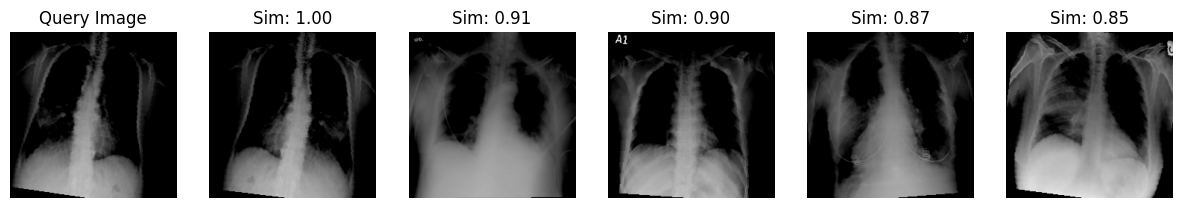

In [23]:

query_index = 0
query_image = test_loader.dataset[query_index][0]  
query_embedding = test_embeddings[query_index]   


top_k = 5
top_k_indices, top_k_similarities = retrieve_similar_images(query_embedding, test_embeddings, [img[0] for img in test_loader.dataset], top_k=top_k)


retrieved_images = [test_loader.dataset[idx][0] for idx in top_k_indices]

visualize_retrieval(query_image, retrieved_images, top_k_similarities)


In [24]:
import numpy as np

def precision_at_k(query_label, retrieved_labels, k):
    
    relevant = np.array(retrieved_labels[:k]) == query_label
    return np.sum(relevant) / k


k = 5  
precision_scores = []

for query_idx in range(len(test_embeddings)):

    query_embedding = test_embeddings[query_idx]
    query_label = test_labels[query_idx]
    

    similarities = np.dot(test_embeddings, query_embedding) / (
        np.linalg.norm(test_embeddings, axis=1) * np.linalg.norm(query_embedding)
    )
    
    top_k_indices = np.argsort(-similarities)[1:k + 1]  
    top_k_labels = test_labels[top_k_indices]
    
    precision = precision_at_k(query_label, top_k_labels, k)
    precision_scores.append(precision)

mean_precision_at_k = np.mean(precision_scores)
print(f"Mean Precision@{k}: {mean_precision_at_k:.4f}")


Mean Precision@5: 0.3314


In [32]:
import numpy as np

def calculate_mAP(query_embeddings, query_labels, database_embeddings, database_labels, top_k=None):
   
    query_embeddings = query_embeddings / np.linalg.norm(query_embeddings, axis=1, keepdims=True)
    database_embeddings = database_embeddings / np.linalg.norm(database_embeddings, axis=1, keepdims=True)

    similarities = np.dot(query_embeddings, database_embeddings.T)
    
    all_AP = [] 
    
    for query_idx, query_label in enumerate(query_labels):

        sorted_indices = np.argsort(-similarities[query_idx])  
        sorted_labels = database_labels[sorted_indices]
        

        relevant = (sorted_labels == query_label).astype(int)
        

        if top_k is not None:
            relevant = relevant[:top_k]
        

        precisions = []
        num_relevant = 0
        for i, rel in enumerate(relevant, start=1):  
            if rel == 1:
                num_relevant += 1
                precisions.append(num_relevant / i)
        if num_relevant > 0:
            AP = np.mean(precisions)
        else:
            AP = 0.0
        
        all_AP.append(AP)
    
    mAP = np.mean(all_AP)
    return mAP

mAP = calculate_mAP(
    query_embeddings=test_embeddings, 
    query_labels=test_labels, 
    database_embeddings=test_embeddings, 
    database_labels=test_labels,
    top_k=5  
)

print(f"Mean Average Precision (mAP): {mAP:.4f}")


Mean Average Precision (mAP): 0.9272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73333335].


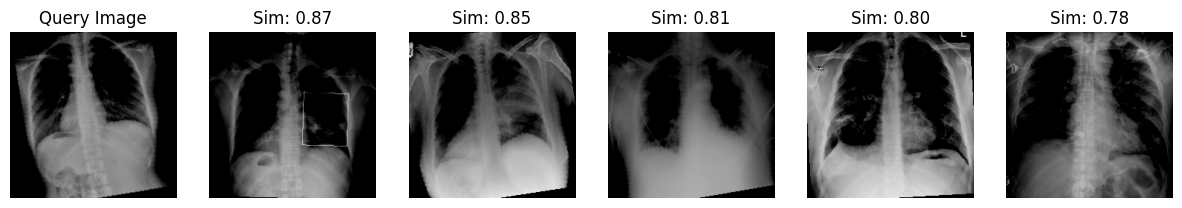

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].


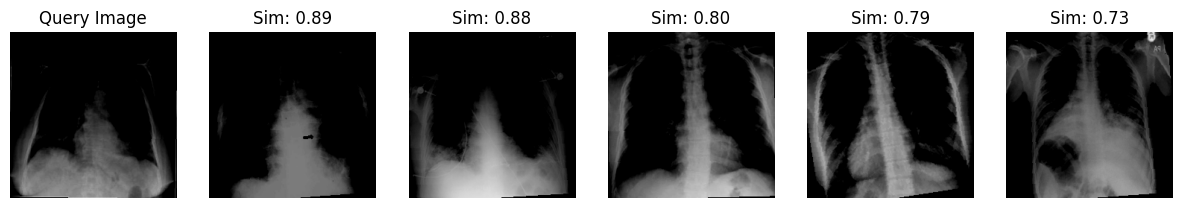

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5686275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


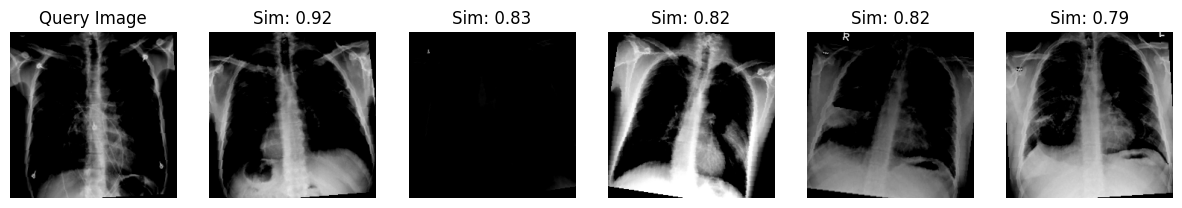

In [25]:
def visualize_batch_retrieval(test_embeddings, test_labels, test_loader, k=5, num_queries=3):
    for query_idx in np.random.choice(len(test_embeddings), num_queries, replace=False):
        query_embedding = test_embeddings[query_idx]
        query_label = test_labels[query_idx]
        query_image = test_loader.dataset[query_idx][0].permute(1, 2, 0).numpy() 
        

        similarities = np.dot(test_embeddings, query_embedding) / (
            np.linalg.norm(test_embeddings, axis=1) * np.linalg.norm(query_embedding)
        )
        top_k_indices = np.argsort(-similarities)[1:k + 1]  
        top_k_labels = test_labels[top_k_indices]
        retrieved_images = [test_loader.dataset[idx][0].permute(1, 2, 0).numpy() for idx in top_k_indices]

        visualize_retrieval(query_image, retrieved_images, similarities[top_k_indices])


visualize_batch_retrieval(test_embeddings, test_labels, test_loader, k=5, num_queries=3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Found 163 near-duplicate pairs.
Pair (0, 1) - Similarity: 0.9035


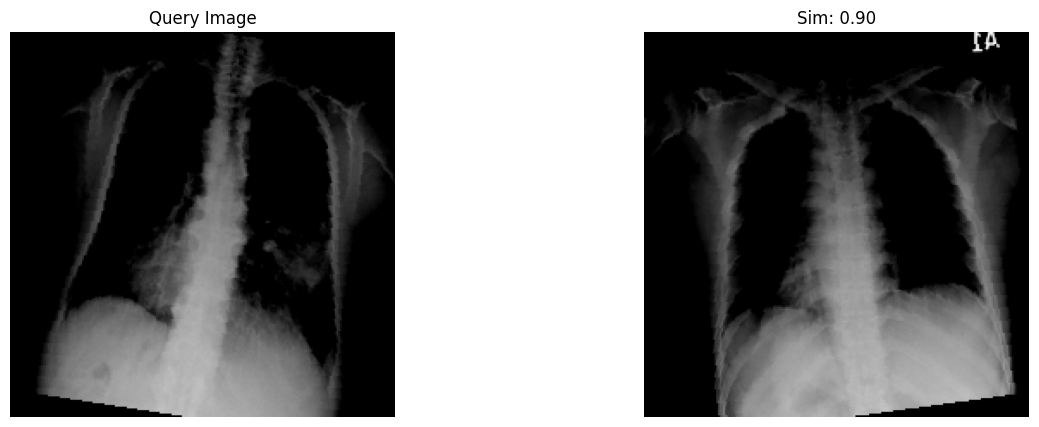

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.67058825].


Pair (0, 5) - Similarity: 0.8652


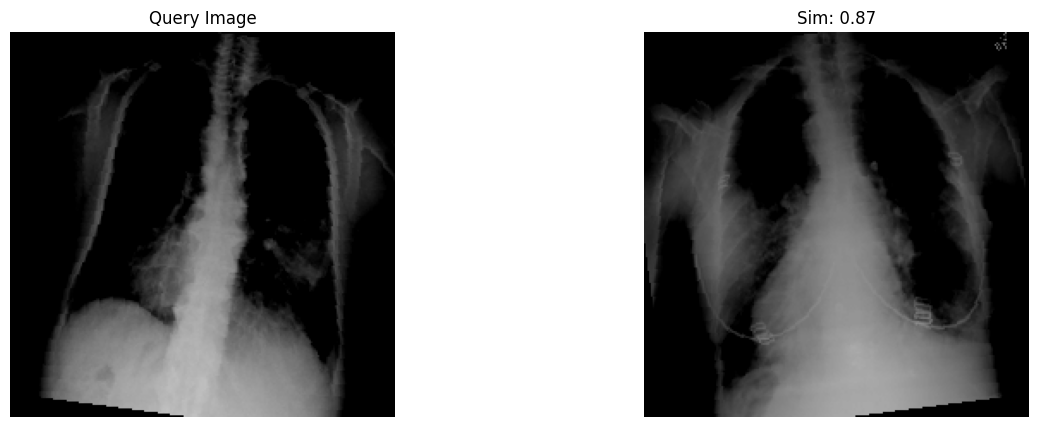

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7019608].


Pair (0, 6) - Similarity: 0.9061


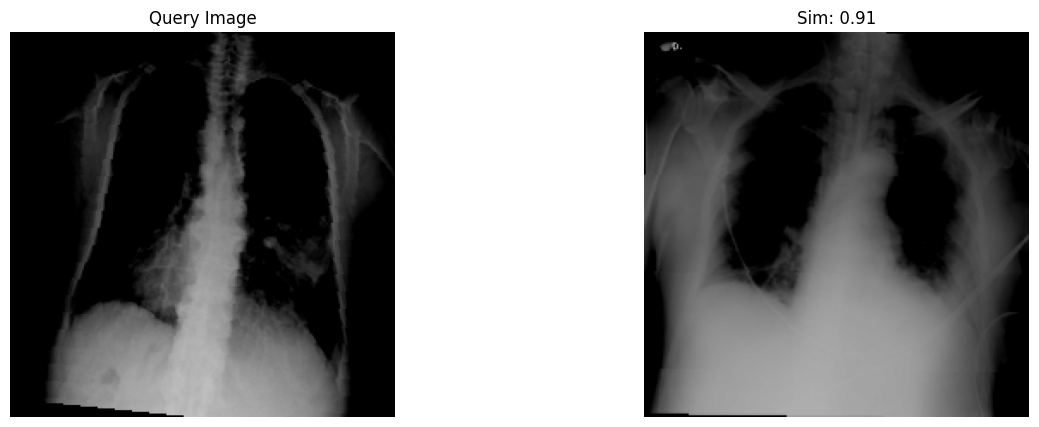

Pair (0, 11) - Similarity: 0.8253


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.827451].


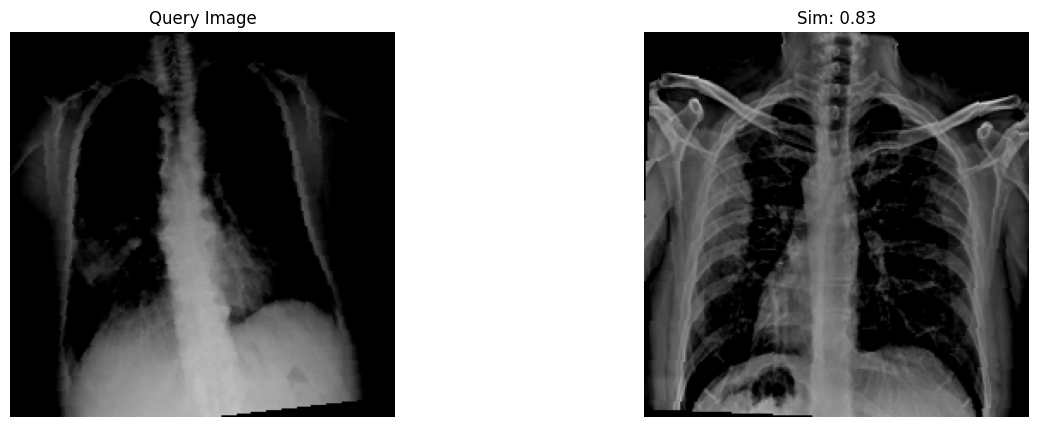

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7176471].


Pair (0, 12) - Similarity: 0.8345


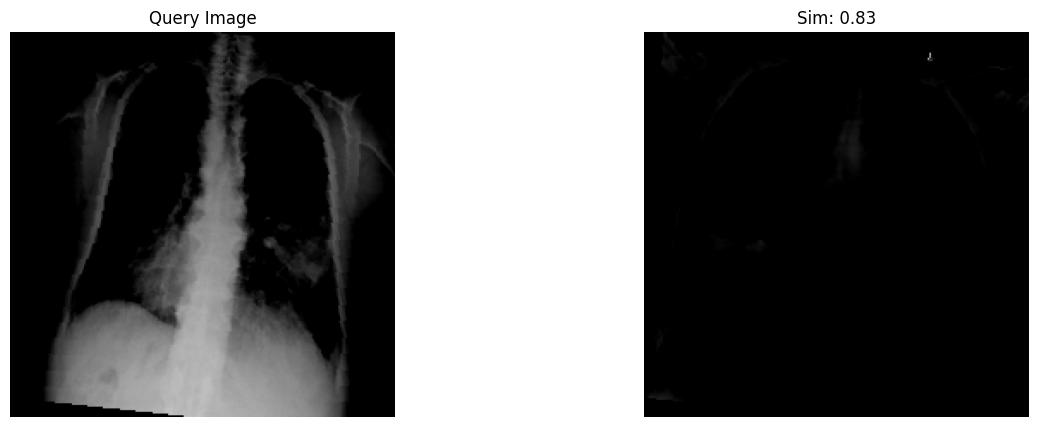

In [31]:
def find_near_duplicates(embeddings, threshold=0.9):

    near_duplicates = []
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):  
            similarity = np.dot(embeddings[i], embeddings[j]) / (
                np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
            )
            if similarity > threshold:
                near_duplicates.append((i, j, similarity))
    return near_duplicates


near_duplicates = find_near_duplicates(test_embeddings, threshold=0.80)
print(f"Found {len(near_duplicates)} near-duplicate pairs.")


for idx1, idx2, sim in near_duplicates[:5]: 
    image1 = test_loader.dataset[idx1][0].permute(1, 2, 0).numpy()
    image2 = test_loader.dataset[idx2][0].permute(1, 2, 0).numpy()
    print(f"Pair ({idx1}, {idx2}) - Similarity: {sim:.4f}")
    visualize_retrieval(image1, [image2], [sim])
